In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

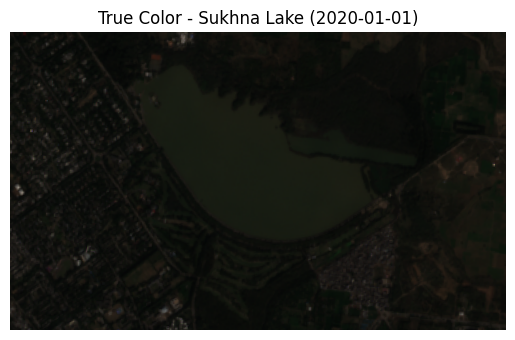

In [2]:
true_color_image = np.load(os.path.join(data_dir, 'sukhna_lake_true-color_2020-01-01.npy'))

# Plot the image
plt.figure()
plt.imshow(true_color_image)
plt.axis('off')
plt.title('True Color - Sukhna Lake (2020-01-01)')
plt.show()

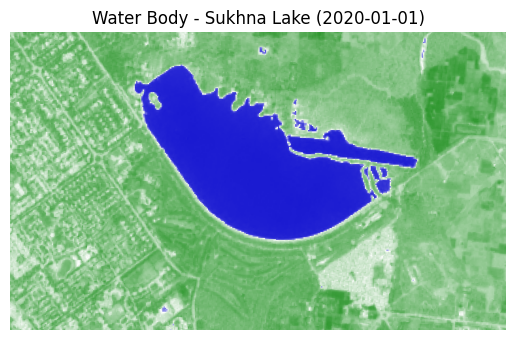

In [3]:
water_image = np.load(os.path.join(data_dir, 'sukhna_lake_ndwi_2020-01-01.npy'))

# Plot the image
plt.figure()
plt.imshow(water_image)
plt.axis('off')
plt.title('Water Body - Sukhna Lake (2020-01-01)')
plt.show()

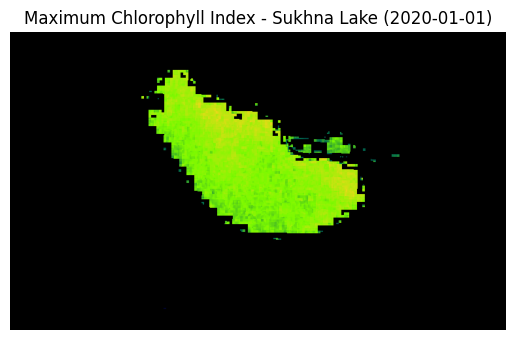

In [4]:
chlorophyll_image = np.load(os.path.join(data_dir, 'sukhna_lake_blackbg_chlorophyll_2020-01-01.npy'))

# Plot the image
plt.figure()
plt.imshow(chlorophyll_image)
plt.axis('off')
plt.title('Maximum Chlorophyll Index - Sukhna Lake (2020-01-01)')
plt.show()

In [5]:
# Define the length and width of each pixel in meters
pixel_length = 5  # meters
pixel_width = 5   # meters
pixel_area = pixel_length * pixel_width  # square meters

reference_colors = np.array([
    [1, 4, 42],    # Very dark blue
    [0, 106, 78],  # Dark teal
    [124, 250, 0], # Bright yellow-green
    [241, 215, 27],# Mustard yellow
    [255, 0, 0]    # Pure red
])

# Function to categorize a pixel
def categorize_pixel(pixel, reference_colors):
    # Only consider the RGB part of the pixel
    distances = np.linalg.norm(reference_colors - pixel[:3], axis=1)
    return np.argmin(distances)

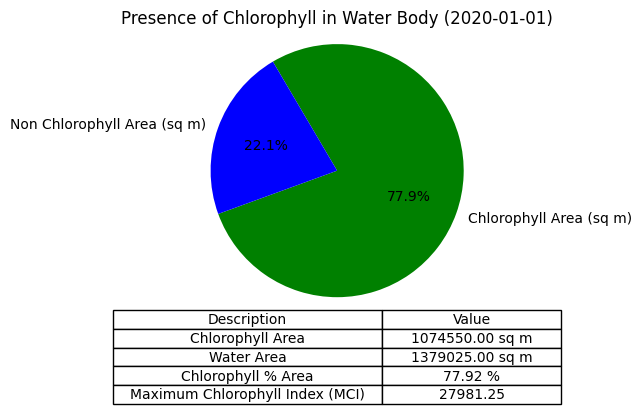

In [6]:
total_pixels_count = chlorophyll_image.shape[0] * chlorophyll_image.shape[1]

# Define blue pixels (assuming RGBA image)
blue_pixels_mask = (water_image[:, :, 2] > water_image[:, :, 0]) & (water_image[:, :, 2] > water_image[:, :, 1]) & (water_image[:, :, 3] != 0)

# Create a copy of the image to modify
blue_image = np.zeros_like(water_image)
blue_pixels_count = np.sum(blue_pixels_mask)

# Define black pixels (assuming RGBA image)
black_pixels_mask = np.all(chlorophyll_image[:, :, :3] == [0, 0, 0], axis=-1) & (chlorophyll_image[:, :, 3] != 0)

# Define non-black pixels mask
non_black_pixels_mask = ~black_pixels_mask
non_black_pixels = chlorophyll_image[non_black_pixels_mask]
non_black_pixels = non_black_pixels.reshape(-1, chlorophyll_image.shape[2])
categorized_pixels = [categorize_pixel(pixel, reference_colors) for pixel in non_black_pixels]
category_counts = np.bincount(categorized_pixels, minlength=len(reference_colors))
concentration_values = np.array([0, 0.0125, 0.0250, 0.0375, 0.05]) 
total_concentration = np.sum(category_counts * concentration_values)
total_mci = total_concentration * pixel_area

black_pixels_count = np.sum(black_pixels_mask)
non_black_pixels_count = total_pixels_count - black_pixels_count
non_black_pixels_area = non_black_pixels_count * pixel_area  # square meters
water_pixels_area = blue_pixels_count * pixel_length * pixel_width  # square meters

# Create a pie chart
labels = [
    'Chlorophyll Area (sq m)',
    'Non Chlorophyll Area (sq m)'
]
sizes = [non_black_pixels_area, water_pixels_area - non_black_pixels_area]
colors = ['green', 'blue']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=200)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Presence of Chlorophyll in Water Body (2020-01-01)')

# Create a table
table_data = [
    ["Chlorophyll Area", f"{non_black_pixels_area:.2f} sq m"],
    ["Water Area", f"{water_pixels_area:.2f} sq m"],
    ["Chlorophyll % Area", f"{non_black_pixels_area / water_pixels_area * 100:.2f} %"],
    ["Maximum Chlorophyll Index (MCI)", f"{total_mci:.2f}"]
]
colWidths = [0.6, 0.4]  # Adjust these values as needed

table = plt.table(cellText=table_data, colLabels=["Description", "Value"], loc='bottom', cellLoc='center', colWidths=colWidths)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.show()